In [1]:
import sys
sys.path.append("..")

import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import utils_library.visualization.visualizations as vis
import applications.model_wrapper
import utils_library.post_processing.post as post
import utils_library.configs.draw_config as draw_config
import utils_library.configs.post_config as post_config
import utils_library.configs.keypoints_config as kpts_config
import utils_library.configs.default_config as def_config

post.Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
post.Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)


In [2]:
def preprocess_img(img):
    """
    This function implements the preprocessing of input image.
    Input original img, it will:
    1. add newaxis to first dimension
    2. fix image height to 368 and proportionally resize image width
    """
    inHeight = img.shape[0]
    inWidth = img.shape[1]
    frameHeight = 368
    frameWidth = round(frameHeight/inHeight * inWidth)
    
    input_img = tf.image.resize(img, (frameHeight, frameWidth))
    #input_img = tf.image.resize(img, (inHeight, inWidth))
    input_img = tf.image.convert_image_dtype(input_img, dtype=tf.float32)
    
    input_img = input_img[tf.newaxis, ...]

    return input_img
    
    

In [3]:
## configs
#model_path = "./trained_models/model11_test-15Sun1219-2101/"
model_path = "./trained_models/mobilenet_model_RGBD"
img_path = "./self_dataset/RGBD_imgs/left_Explorer_HD720_SN15385_19-32-29.png"

# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

In [4]:
# loading model and check architecture
model = tf.keras.models.load_model(model_path)

In [5]:
# loading images and do preprocessing
img_rgbd = plt.imread(img_path)
img_rgb = (img_rgbd[...,:3]*255).astype('uint8')
input_img = preprocess_img(img_rgbd)
#img_rgb = input_img[0,...,:3].numpy()

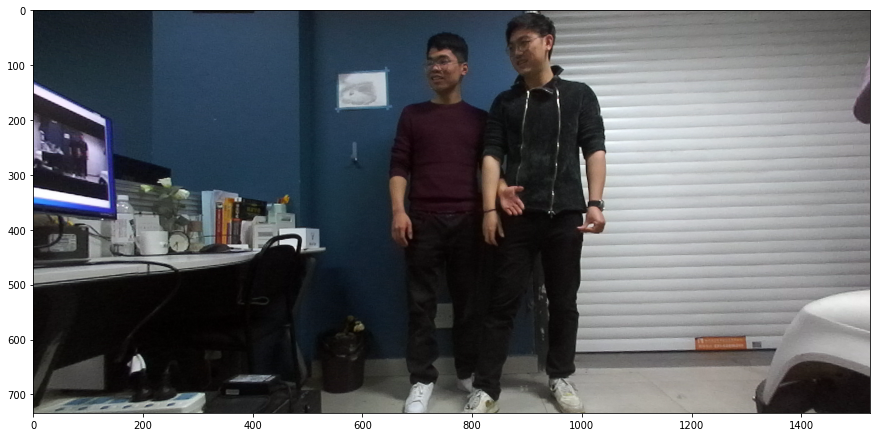

In [6]:
plt.figure(figsize=[15,15])
plt.imshow(img_rgbd[...,:3])

In [7]:
start_time = time.time()
pafs, kpts = model.predict(input_img)
end_time = time.time()
model_time = end_time - start_time

start_time = time.time()
skeletonizer = post.Skeletonizer(kpts[0], pafs[0])
skeletons = skeletonizer.create_skeletons()
end_time = time.time()
post_time = end_time - start_time

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to uint16. Precision may be lost.
  d[key] = value
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to float32. Precision may be lost.
  d[key] = value


In [8]:
print("Model time usage: ", model_time)
print("Post time usage: ", post_time)

Model time usage:  3.397202968597412
Post time usage:  1.2661969661712646


In [9]:
skeleton_drawer = vis.SkeletonDrawer(img_rgb, draw_config)
for skeleton in skeletons:
    skeleton.draw_skeleton(skeleton_drawer.joint_draw, skeleton_drawer.kpt_draw)

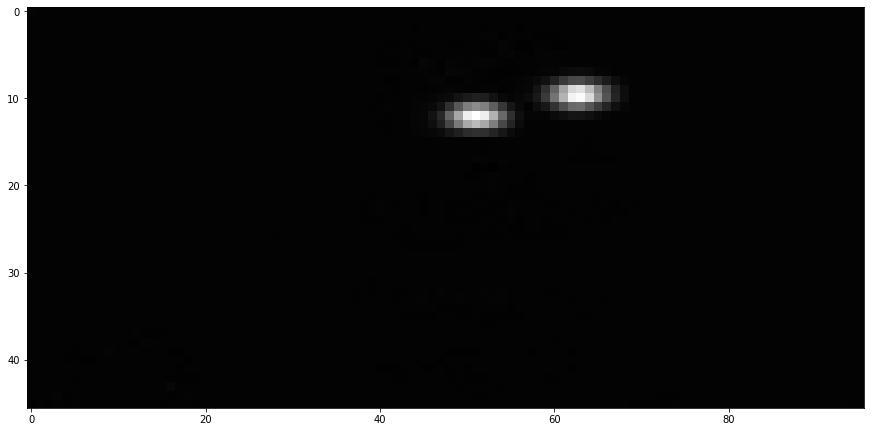

In [10]:
plt.figure(figsize=[15,15])
plt.imshow(kpts[0][:,:,10], 'gray')

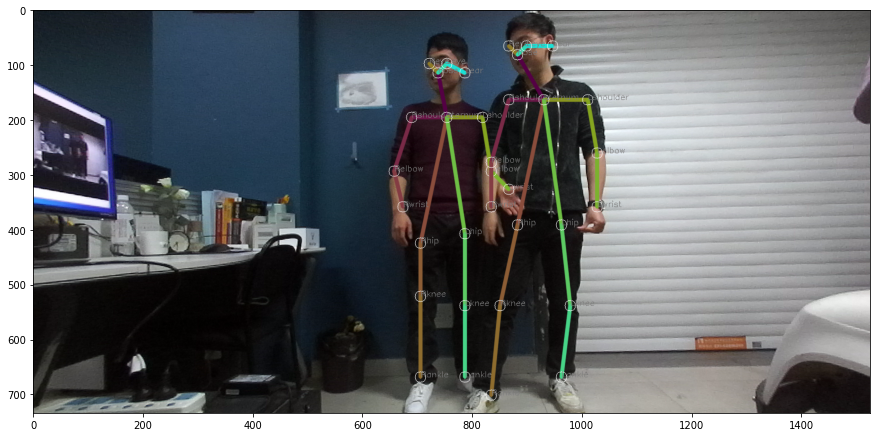

In [11]:
plt.figure(figsize=[15,15])
plt.imshow(img_rgb)

In [12]:
# creating json file
import json

result_dict = {}
n = 1
for skeleton in skeletons:
    person_name = "person" + str(n)
    result_dict[person_name] = {}
    for name in skeleton.keypoints:
        result_dict[person_name][name] = [skeleton.keypoints[name][0] * img_rgb.shape[0], skeleton.keypoints[name][1] * img_rgb.shape[1]]
    n += 1

result_json = json.dumps(result_dict)